<h1>Convolutional Neural Network

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Number of GPUs available : ",len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

Number of GPUs available :  0


<h2>Data Preperation

In [3]:
if os.path.isdir('Datasets/train/dog') is False:
    os.makedirs('Datasets/train/dog')
    os.makedirs('Datasets/test/dog')
    os.makedirs('Datasets/train/cat')
    os.makedirs('Datasets/test/cat')
    os.makedirs('Datasets/valid/dog')
    os.makedirs('Datasets/valid/cat')
    
    for c in random.sample(glob.glob('Datasets/train/cat*'),500):
        shutil.move(c, 'Datasets/train/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),500):
        shutil.move(c, 'Datasets/train/dog')
    for c in random.sample(glob.glob('Datasets/train/cat*'),50):
        shutil.move(c, 'Datasets/test/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),50):
        shutil.move(c, 'Datasets/test/dog')
    for c in random.sample(glob.glob('Datasets/train/cat*'),100):
        shutil.move(c, 'Datasets/valid/cat')
    for c in random.sample(glob.glob('Datasets/train/dog*'),100):
        shutil.move(c, 'Datasets/valid/dog')

In [4]:
train_path='Datasets/train'
test_path='Datasets/test'
valid_path='Datasets/valid'

In [5]:
# Preprocess Image Data for Keras
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'],batch_size=10)
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'],batch_size=10)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [7]:
# Pull out the first batch of the dataset (.ie) first 10 images of the training batch
imgs, labels = next(train_batches)

In [8]:
#This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in the row
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

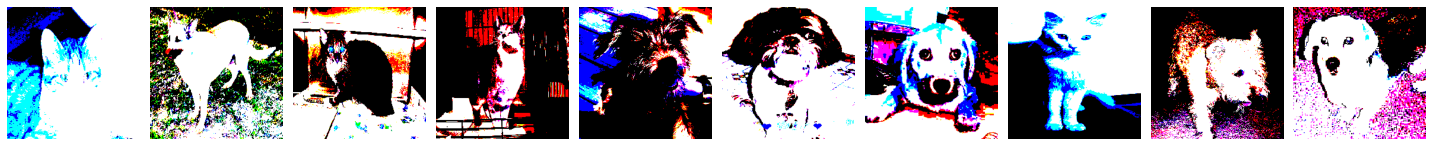

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

<h2>Build and Train CNN

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
r = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    steps_per_epoch=100,
    validation_steps=20,
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 51s - loss: 20.2206 - accuracy: 0.5570 - val_loss: 5.4914 - val_accuracy: 0.6050
Epoch 2/10
100/100 - 49s - loss: 2.8713 - accuracy: 0.7400 - val_loss: 5.9775 - val_accuracy: 0.6150
Epoch 3/10
100/100 - 49s - loss: 0.4937 - accuracy: 0.9170 - val_loss: 2.9050 - val_accuracy: 0.6600
Epoch 4/10
100/100 - 49s - loss: 0.1869 - accuracy: 0.9600 - val_loss: 3.1299 - val_accuracy: 0.7000
Epoch 5/10
100/100 - 49s - loss: 0.0861 - accuracy: 0.9810 - val_loss: 3.8193 - val_accuracy: 0.5750
Epoch 6/10
100/100 - 49s - loss: 0.0219 - accuracy: 0.9890 - val_loss: 3.0226 - val_accuracy: 0.6750
Epoch 7/10
100/100 - 50s - loss: 0.0165 - accuracy: 0.9940 - val_loss: 3.1346 - val_accuracy: 0.6600
Epoch 8/10
100/100 - 49s - loss: 0.0108 - accuracy: 0.9950 - val_loss: 2.7834 - val_accuracy: 0.6750
Epoch 9/10
100/100 - 49s - loss: 5.1708e-04 - accuracy: 1.0000 - val_loss: 2.7849 - val_accuracy: 0.6700
Epoch 10/10
100/100 - 49s - loss: 3.4224e-04 - accuracy: 1.0000 - val_loss: 2.7828 - v

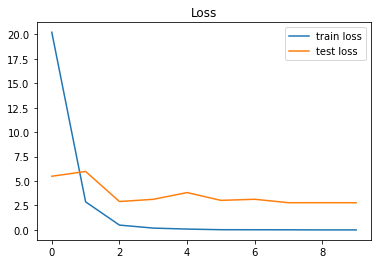

In [14]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title('Loss')
plt.legend()
plt.show()

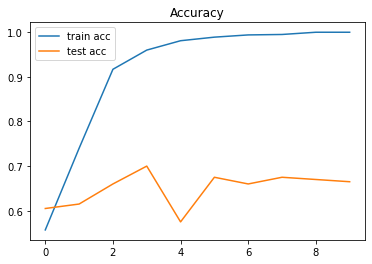

In [15]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title('Accuracy')
plt.legend()
plt.show()

<h2>Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

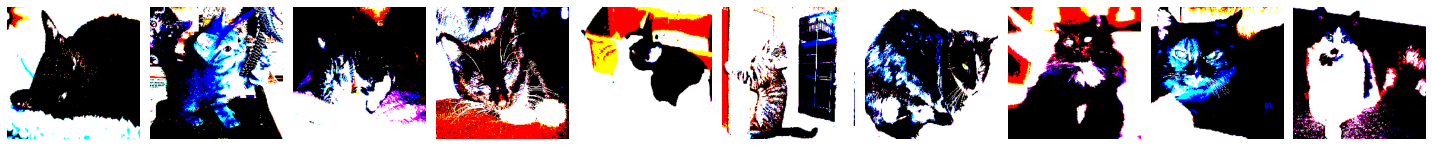

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [16]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
predictions = model.predict(x=test_batches, verbose=0)

In [19]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [20]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [21]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues
                         ):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Conusion Matrix without Normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else "black"
                )
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

In [22]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Conusion Matrix without Normalization
[[32 18]
 [14 36]]


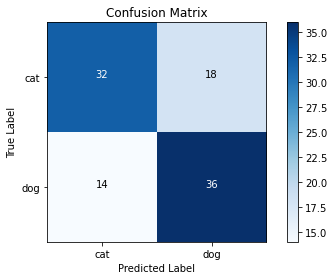

In [23]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [24]:
acc=sum(cm.diagonal())/sum(sum(cm))*100
print("Accuracy = "+str(acc)+"%")

Accuracy = 68.0%
